# Testing Sentinel 1-A Water Index for Water Detection and Mapping

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc), 

## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.


A couple of very instructive papers on Lake Chad

- [The Lake Chad hydrology under current climate change](https://www.nature.com/articles/s41598-020-62417-w)
- [Recent Surface Water Extent of Lake Chad from Multispectral Sensors and GRACE](https://www.mdpi.com/1424-8220/18/7/2082)

## Description

The notebook demonstrates how to:

1. Load satellite data over the water body of interest.
2. Calculate the water index SWI.
3. Generate a median composite of the SWI water index.
4. Threshold the median composite of the SWI water index.
5. Compare the results to different datasets.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

In [1]:
# Uncomment the line below to install the tabulate module.
# !pip install tabulate

### Load packages
Import Python packages that are used for the analysis.

In [2]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.colors as mcolours
from tabulate import tabulate
from odc.algo import geomedian_with_mads

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    cohen_kappa_score,
)

from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, xr_animation, plot_lulc

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [3]:
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36133 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:38705 Dashboard: /user/victoria/proxy/36133/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [4]:
dc = datacube.Datacube(app='water_extent')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `vector_file`: The path to the shapefile or geojson that will define the analysis area of the study.
* `time_range` : The date range to analyse (e.g. `('2017', '2019')`.
* `resolution` : The pixel resolution of the satellite data. `(-30,30)` for Landsat or `(-10,10)` for Sentinel-2.
* `dask_chunks`: Chunk sizes to use for dask.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers Lake Chad. 

**Current default is Lake Sulunga. Tanzania.**

In [5]:
# Define the area of interest.
# vector_file = 'data/lake_chad_extent.geojson'
# gdf = gpd.read_file(vector_file)

# bbox=list(gdf.total_bounds)
# lon_range = (bbox[0], bbox[2])
# lat_range = (bbox[1], bbox[3])

# Define the area of interest.
lat = -5.9460  # -6.0873
lon = 35.5188  # 35.1817

lat_buffer = 0.03
lon_buffer = 0.03

# Combine central lat,lon with buffer to get area of interest.
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Define the time range.
time_range = "2020"

# Define the resolution to load the data.
resolution = (-10, 10)

# Define the dask chunks to be used.
dask_chunks = {"time": 1, "x": 1500, "y": 1500}

## View the area of Interest on an interactive map
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [6]:
display_map(lon_range, lat_range)

## Load the Sentinel-1 data

The code below will create a query dictionary for our region of interest, and then load Sentinel-1 satellite data.
For more information on loading data, see the [Loading data notebook](../Beginners_guide/03_Loading_data.ipynb).

In [7]:
# Create a query object.
query = {
    "x": lon_range,
    "y": lat_range,
    "resolution": resolution,
    "output_crs": "EPSG:6933",
    "time": time_range,
    "dask_chunks": dask_chunks,
}

# Load the Sentinel-1 data.
ds = load_ard(
    dc=dc, products=["s1_rtc"], measurements=["vv", "vh"], group_by="solar_day", **query
)

print(ds)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 86 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 86, y: 763, x: 580)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-07T03:12:45.511815 ... 2020-12...
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


/env/lib/python3.8/site-packages/datacube/utils/geometry/_base.py:608: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return type(geom)([segmentize_shapely(g) for g in geom])


## Convert the Sentinel-1 Digital Number (DN) values to Decibel values (dB)

The Sentinel-1 backscatter data is provided as digital number (DN), which can be converted to backscatter in decibel unit (dB) using the function:

\begin{equation}
10 * \log_{10}(\text{DN})
\end{equation}


It is often useful to convert the backscatter to decible (dB) for analysis because the backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [8]:
# Convert DN to db values.
ds["vv_db"] = 10 * xr.ufuncs.log10(ds.vv)
ds["vh_db"] = 10 * xr.ufuncs.log10(ds.vh)

## Calculate the Sentinel-1A Water Index (SWI)
The Sentinel-1A water index (SWI) is calculated as follows:

\begin{equation} 
\text{SWI} = 0.1747 * \beta _{vv} + 0.0082 * \beta _{vh} * \beta _{vv} + 0.0023 * \beta _{vv}^{2} - 0.0015 * \beta _{vh}^{2} + 0.1904
\end{equation}

where  βvh and βvv represent the backscattering coefficient in VH polarization and VV polarization, respectively ([Tian et al., 2017](https://doi.org/10.3390/rs9060521)). 

In [9]:
# Calculate the Sentinel-1A Water Index (SWI)
ds["SWI"] = (
    (0.1747 * ds.vv_db)
    + (0.0082 * ds.vh_db * ds.vv_db)
    + (0.0023 * ds.vv_db ** 2)
    - (0.0015 * ds.vh_db ** 2)
    + 0.1904
)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 86, y: 763, x: 580)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-07T03:12:45.511815 ... 2020-12...
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
    vv_db        (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
    vh_db        (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
    SWI          (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Generate a median value composite image

We will combine all the SWI observations in our in our `ds.SWI` `xarray.DataArray` into a single, complete (or near complete) image representing the median of the time period.

> **Note:** Because our data was lazily loaded with `dask`, the median algorithm itself will not be triggered until we call the `.compute()` method in the next step.

In [10]:
# Obtain the median of all SWI observations for the time period.
median_swi = ds.SWI.median(dim="time")

print(median_swi)

<xarray.DataArray 'SWI' (y: 763, x: 580)>
dask.array<nanmedian, shape=(763, 580), dtype=float32, chunksize=(763, 290), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933


### Run the computation

The `.compute()` method will trigger the computation of the geomedian algorithm above.
This will take about a few minutes to run; view the `dask dashboard` to check the progress.

In [11]:
%%time
median_swi = median_swi.compute()

CPU times: user 942 ms, sys: 67.2 ms, total: 1.01 s
Wall time: 19.9 s


If we print our result, you will see that the `time` dimension has now been removed and we are left with a single image that represents the median of all the satellite images in our initial time series:

In [12]:
print(median_swi)

<xarray.DataArray 'SWI' (y: 763, x: 580)>
array([[-0.15904312, -0.15904312, -0.35027042, ..., -0.408829  ,
        -0.408829  , -0.3908611 ],
       [-0.33595067, -0.33595067, -0.39850464, ..., -0.37829578,
        -0.37829578, -0.41433433],
       [-0.33595067, -0.33595067, -0.39850464, ..., -0.37829578,
        -0.37829578, -0.41433433],
       ...,
       [-0.26490408, -0.26490408, -0.20912361, ..., -0.37857378,
        -0.37857378, -0.39753294],
       [-0.26490408, -0.26490408, -0.20912361, ..., -0.37857378,
        -0.37857378, -0.39753294],
       [-0.23768371, -0.23768371, -0.25455642, ..., -0.38008252,
        -0.38008252, -0.39786503]], dtype=float32)
Coordinates:
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933


## Classify the SWI median composite

[Tian et al. 2020]( https://doi.org/10.3390/s20174872) found that to obtain the best classification results for distinguishing water and non-water from the SWI images, pixels with a value greater than 0.2 are regarded as a water.

In [13]:
water_ds = median_swi > 0.2

# Replace the values True and False with 1 and 0 respectively.
repl_dict = {True: 1, False: 0}

input_array = water_ds.values

out = np.zeros(input_array.shape, dtype=np.int16)

for key in repl_dict:
    out[input_array == key] = repl_dict[key]

water_ds.values = out

print(water_ds)

<xarray.DataArray 'SWI' (y: 763, x: 580)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933


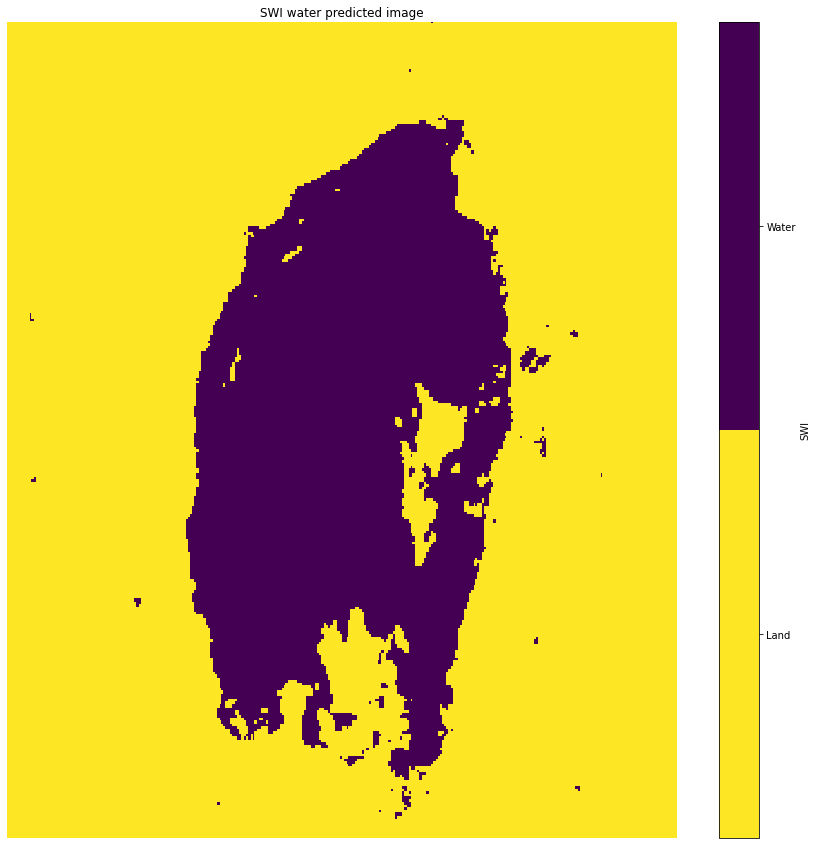

In [14]:
# Plot the water_ds Dataset.
image = water_ds
no_classes = 2
colour_list = ["#fde725", "#440154"]
cmap = mcolours.ListedColormap(colour_list)
bounds = range(0, no_classes + 1)
norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
cblabels = ["Land", "Water"]
im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(15, 15))
cb = im.colorbar
cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
cb.set_ticklabels(cblabels)
plt.axis("off")
plt.title("SWI water predicted image")
plt.show()

In the `water_ds` xarray Dataset the value `1` represents water and the value `0` represents land.

## Accuracy test against the ESA World Cover

In [15]:
# Load the ESA land use land cover product over the same region as the Sentinel 1 dataset.
ds_esa = dc.load(product="esa_worldcover", like=ds.geobox).squeeze()

print(ds_esa)

<xarray.Dataset>
Dimensions:         (y: 763, x: 580)
Coordinates:
    time            datetime64[ns] 2020-07-01T12:00:00
  * y               (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x               (x) float64 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref     int32 6933
Data variables:
    classification  (y, x) uint8 30 30 30 30 20 20 20 ... 40 40 40 40 40 40 40
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref


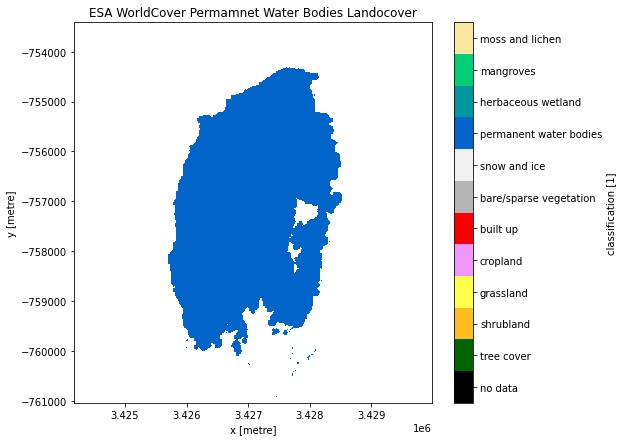

In [16]:
# Plot the  permanent water bodies from the ESA worldcover dataset.
water_esa = ds_esa.where(ds_esa["classification"] == 80)
plot_lulc(water_esa["classification"], product="ESA", legend=True, figsize=(8, 7))
plt.title("ESA WorldCover Permamnet Water Bodies Landocover");

In [17]:
# Pixels with a value of 80 are classified as permanent water bodies land cover.
# Mask the ESA land cover dataset to retain only pixels with the value 80.
actual = ds_esa["classification"] == 80

# Replace the values True and False with 1 and 0 respectively.
repl_dict = {True: 1, False: 0}

input_array = actual.values

out = np.zeros(input_array.shape, dtype=np.int16)

for key in repl_dict:
    out[input_array == key] = repl_dict[key]

actual.values = out

print(actual)

<xarray.DataArray 'classification' (y: 763, x: 580)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
    time         datetime64[ns] 2020-07-01T12:00:00
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933


In [18]:
## Functions to be imported later from classifications.py
def sklearn_flatten(input_xr):
    """
    Reshape a DataArray or Dataset with spatial (and optionally
    temporal) structure into an np.array with the spatial and temporal
    dimensions flattened into one dimension.
    This flattening procedure enables DataArrays and Datasets to be used
    to train and predict with sklearn models.
    Last modified: November 2021
    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.
    Returns
    ----------
    input_np : numpy.array
        A numpy array corresponding to input_xr.data (or
        input_xr.to_array().data), with dimensions 'x','y' and 'time'
        flattened into a single dimension, which is the first axis of
        the returned array. input_np contains no NaNs.
    """

    # Cast input DataArrays to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()

    # Work around for input_xr Dataset with geographic coordinate reference system.
    if input_xr.geobox.crs.geographic:
        input_xr = input_xr.rename({"longitude": "x", "latitude": "y"})

    # Get the data type for the input_xr Dataset data values.
    data_type = input_xr.to_array().data.dtype

    # Get the number of bands in the input_xr Dataset.
    bands_list = list(input_xr.data_vars)
    nbands = len(bands_list)
    # Create a dictionary of the bands and their index in the list bands_list.
    bands_dict = {k: v for k, v in enumerate(bands_list)}

    # Get the dimensions x , y of the input_xr Dataset.
    height = input_xr.dims["y"]
    width = input_xr.dims["x"]

    # Get the dimension time of the input_xr Dataset.
    # Create an empty numpy array, input_np, in which each column will hold a
    # flattened band/measurement from the input_xr Dataset.
    if "time" in input_xr.dims:
        time = input_xr.dims["time"]
        input_np = np.empty((height * width * time, nbands), dtype=data_type)
    else:
        input_np = np.empty((height * width, nbands), dtype=data_type)

    # Loop through each band in the input_xr Dataset and add it
    # to the numpy array model_input.
    for i, band in bands_dict.items():
        band_array = np.array(input_xr[band])
        input_np[:, i - 1] = band_array.flatten()

    return input_np


def sklearn_unflatten(output_np, input_xr):
    """
    Reshape a numpy array with no 'missing' elements (NaNs) and
    'flattened' spatiotemporal structure into a DataArray matching the
    spatiotemporal structure of the DataArray
    This enables an sklearn model's prediction to be remapped to the
    correct pixels in the input DataArray or Dataset.
    Last modified: November 2021
    Parameters
    ----------
    output_np : numpy.array
        The first dimension's length should correspond to the number of
        valid (non-NaN) pixels in input_xr.
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.
        Dimensions other than 'x', 'y' and 'time' are unaffected by the
        flattening.
    Returns
    ----------
    output_xr : xarray.Dataset
        An xarray.Dataset with the same dimensions 'x', 'y' and 'time'
        as input_xr, and the same valid (non-NaN) pixels. These pixels
        are set to match the data in output_np.
    """

    # The  expected output of a sklearn model prediction should just be
    # a 1 dimensional numpy array, output_np, with the size/columns matching
    # the height * width * time  for the dimensions of the input_xr DataArray/Dataset.

    # Cast the input DataArray to Dataset.
    if isinstance(input_xr, xr.DataArray):
        input_xr = input_xr.to_dataset()

    # Work around for input_xr Dataset with geographic coordinate reference system.
    if input_xr.geobox.crs.geographic:
        input_xr = input_xr.rename({"longitude": "x", "latitude": "y"})

    # Get the dimensions x , y of the input_xr Dataset.
    height = input_xr.dims["y"]
    width = input_xr.dims["x"]

    # Get the dimension time of the input_xr Dataset.
    if "time" in input_xr.dims:
        time = input_xr.dims["time"]
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((time, height, width))
        # Convert the output_np numpy array into a xarray Dataset.
        output_xr = xr.Dataset(
            data_vars=dict(band=(["time", "y", "x"], output_np)),
            coords=dict(
                time=(["time"], input_xr.coords["time"].values),
                y=(["y"], input_xr.coords["y"].values),
                x=(["x"], input_xr.coords["x"].values),
                spatial_ref=input_xr.coords["spatial_ref"].values,
            ),
            attrs=input_xr.attrs,
        )
    else:
        # Reshape the output_np numpy array.
        output_np = output_np.reshape((height, width))
        # Convert the output_np numpy array into a xarray Dataset.
        output_xr = xr.Dataset(
            data_vars=dict(band=(["y", "x"], output_np)),
            coords=dict(
                y=(["y"], input_xr.coords["y"].values),
                x=(["x"], input_xr.coords["x"].values),
                spatial_ref=input_xr.coords["spatial_ref"].values,
            ),
            attrs=input_xr.attrs,
        )

    output_xr = assign_crs(output_xr, input_xr.geobox.crs)

    # Work around for input_xr Dataset with geographic coordinate reference system.
    if input_xr.geobox.crs.geographic:
        output_xr = output_xr.rename({"x": "longitude", "y": "latitude"})

    return output_xr

In [19]:
# Accuracy metrics.

y_true = sklearn_flatten(actual)
y_pred = sklearn_flatten(water_ds)

# Producer's Accuracies.
precision = precision_score(y_true, y_pred, labels=[0, 1], average=None)
water_precision = precision[1] * 100
land_precision = precision[0] * 100

# User's Accuracies.
recall = recall_score(y_true, y_pred, labels=[0, 1], average=None)
water_recall = recall[1] * 100
land_recall = recall[0] * 100

# Overall Accuracy.
accuracy = accuracy_score(y_true, y_pred, normalize=True)
overall_accuracy = accuracy * 100

# Micro-averaged F1 score.
f1score = f1_score(y_true, y_pred, average="micro") * 100

# Kappa coefficient.
kappa = cohen_kappa_score(y_true, y_pred)


print(
    "\033[1m"
    + "\033[91m"
    + "Radar Water Mapping using SWI compared with ESA Worldcover"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: \t\t", round(overall_accuracy, 3))
print("Micro-averaged F1 score: \t", round(f1score, 3))
print("Kappa coefficient: \t\t", round(kappa, 3))
print("")
table1 = [
    (
        "Producer's Accuracy",
        round(water_precision, 3),
        round(land_precision, 3),
    ),
    (
        "User's Accuracy",
        round(water_recall, 3),
        round(land_recall, 3),
    ),
]
print(tabulate(table1, stralign="left", headers=("", "Water", "Land")))

Radar Water Mapping using SWI compared with ESA Worldcover

Overall Accuracy: 		 96.494
Micro-averaged F1 score: 	 96.494
Kappa coefficient: 		 0.908

                       Water    Land
-------------------  -------  ------
Producer's Accuracy   91.777  98.138
User's Accuracy       94.5    97.162


## Accuracy test against WOfS annual summaries

In [20]:
wofs_annual = dc.load(product="wofs_ls_summary_annual", like=ds.geobox, time="2020")

print(wofs_annual)

<xarray.Dataset>
Dimensions:      (time: 1, y: 763, x: 580)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 25 25 26 26 26 26 26 ... 23 23 23 23 23 23
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref


The plot below will have values that range from 0 to 1. Values that approach 1 indicate a permanent waterbody, while values closer to 0 indicate a more ephemeral or seasonal waterbody.

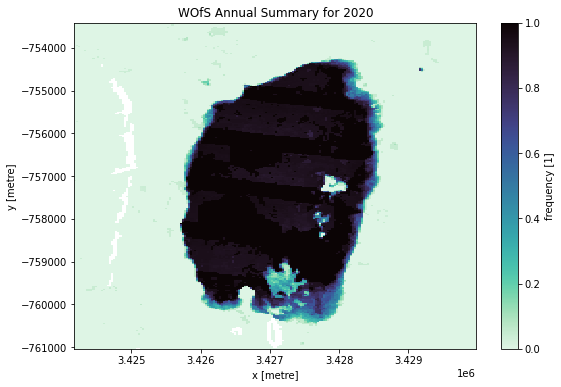

In [21]:
wofs_annual.frequency.plot(size=6, cmap=sns.color_palette("mako_r", as_cmap=True))
plt.title("WOfS Annual Summary for 2020");

If wofs_annual.frequency is > 0.20, then the pixel will be considered regular open water during the year. 

In [22]:
water_threshold = 0.20

water_wofs = wofs_annual.frequency > water_threshold

# Replace the values True and False with 1 and 0 respectively.
repl_dict = {True: 1, False: 0}

input_array = water_wofs.values

out = np.zeros(input_array.shape, dtype=np.int16)

for key in repl_dict:
    out[input_array == key] = repl_dict[key]

water_wofs.values = out

print(water_wofs)

<xarray.DataArray 'frequency' (time: 1, y: 763, x: 580)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int16)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933


In [23]:
# Accuracy metrics.

y_true = sklearn_flatten(water_wofs)
y_pred = sklearn_flatten(water_ds)

# Producer's Accuracies.
precision = precision_score(y_true, y_pred, labels=[0, 1], average=None)
water_precision = precision[1] * 100
land_precision = precision[0] * 100

# User's Accuracies.
recall = recall_score(y_true, y_pred, labels=[0, 1], average=None)
water_recall = recall[1] * 100
land_recall = recall[0] * 100

# Overall Accuracy.
accuracy = accuracy_score(y_true, y_pred, normalize=True)
overall_accuracy = accuracy * 100

# Micro-averaged F1 score.
f1score = f1_score(y_true, y_pred, average="micro") * 100

# Kappa coefficient.
kappa = cohen_kappa_score(y_true, y_pred)


print(
    "\033[1m"
    + "\033[91m"
    + "Radar Water Mapping using SWI compared with WOfS annual summaries"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: \t\t", round(overall_accuracy, 3))
print("Micro-averaged F1 score: \t", round(f1score, 3))
print("Kappa coefficient: \t\t", round(kappa, 3))
print("")
table1 = [
    (
        "Producer's Accuracy",
        round(water_precision, 3),
        round(land_precision, 3),
    ),
    (
        "User's Accuracy",
        round(water_recall, 3),
        round(land_recall, 3),
    ),
]
print(tabulate(table1, stralign="left", headers=("", "Water", "Land")))

Radar Water Mapping using SWI compared with WOfS annual summaries

Overall Accuracy: 		 95.523
Micro-averaged F1 score: 	 95.523
Kappa coefficient: 		 0.889

                       Water    Land
-------------------  -------  ------
Producer's Accuracy   98.895  94.347
User's Accuracy       85.913  99.593


## Accuracy assessment against MNDWI

In [24]:
# Create a query object.
query = {
    "x": lon_range,
    "y": lat_range,
    "resolution": (-10, 10),
    "output_crs": "EPSG:6933",
    "time": time_range,
    "dask_chunks": dask_chunks,
}


# load Sentinel 2 data
ds_S2 = load_ard(
    dc=dc,
    products=["s2_l2a"],
    measurements=["green", "swir_1"],
    mask_filters=[("opening", 3), ("dilation", 2)],  # improve cloud mask
    group_by="solar_day",
    **query
)


print(ds_S2)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 72 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 72, y: 763, x: 580)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T08:01:37 ... 2020-12-24T08:...
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 763, 580), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [25]:
# Calculate the MNDWI water index
ds_S2 = calculate_indices(ds=ds_S2, index="MNDWI", collection="s2", drop=True)

Dropping bands ['green', 'swir_1']


In [26]:
median_MNDWI = ds_S2.MNDWI.median("time")

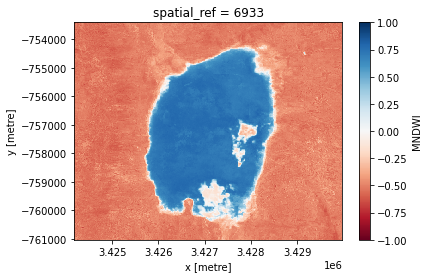

In [27]:
median_MNDWI.plot.imshow( cmap='RdBu', vmax=1.0, vmin=-1.0);

Calculates the area of pixels classified as water (if MNDWI is > 0, the water)

In [28]:
water_MNDWI = median_MNDWI > 0

# Replace the values True and False with 1 and 0 respectively.
repl_dict = {True: 1, False: 0}

input_array = water_MNDWI.values

out = np.zeros(input_array.shape, dtype=np.int16)

for key in repl_dict:
    out[input_array == key] = repl_dict[key]

water_MNDWI.values = out

print(water_MNDWI)

<xarray.DataArray 'MNDWI' (y: 763, x: 580)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)
Coordinates:
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933


In [29]:
# Accuracy metrics.

y_true = sklearn_flatten(water_MNDWI)
y_pred = sklearn_flatten(water_ds)

# Producer's Accuracies.
precision = precision_score(y_true, y_pred, labels=[0, 1], average=None)
water_precision = precision[1] * 100
land_precision = precision[0] * 100

# User's Accuracies.
recall = recall_score(y_true, y_pred, labels=[0, 1], average=None)
water_recall = recall[1] * 100
land_recall = recall[0] * 100

# Overall Accuracy.
accuracy = accuracy_score(y_true, y_pred, normalize=True)
overall_accuracy = accuracy * 100

# Micro-averaged F1 score.
f1score = f1_score(y_true, y_pred, average="micro") * 100

# Kappa coefficient.
kappa = cohen_kappa_score(y_true, y_pred)


print(
    "\033[1m" + "\033[91m" + "Radar Water Mapping using SWI compared with MNDWI"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: \t\t", round(overall_accuracy, 3))
print("Micro-averaged F1 score: \t", round(f1score, 3))
print("Kappa coefficient: \t\t", round(kappa, 3))
print("")
table1 = [
    (
        "Producer's Accuracy",
        round(water_precision, 3),
        round(land_precision, 3),
    ),
    (
        "User's Accuracy",
        round(water_recall, 3),
        round(land_recall, 3),
    ),
]
print(tabulate(table1, stralign="left", headers=("", "Water", "Land")))

Radar Water Mapping using SWI compared with MNDWI

Overall Accuracy: 		 96.776
Micro-averaged F1 score: 	 96.776
Kappa coefficient: 		 0.918

                       Water    Land
-------------------  -------  ------
Producer's Accuracy   96.996  96.699
User's Accuracy       91.107  98.929


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [30]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [31]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-12-07'